In [1]:
#@title Overview loading

# Evaluating met and parameter data to understand metabolic landscape
# TODO: normalize by the 1,1 condition done every day? Or at least remove the offset based on that? use mass as well?
# TODO: for cost function, also penalize the regions with large std in predictions to prevent exploration of those, in case they are the wrong concavity?
import os
from google.colab import drive
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import pickle as pkl
from numpy.matlib import repmat
import random
import matplotlib.colors as mcolors
#!sudo apt install font-manager

drive.mount('/content/drive/')
main_folder = 'drive/Shareddrives/Ability Lab/Simulating HILO/Code/'#"drive/My Drive/WHILO/Met Landscape/Code/"
save_dir = main_folder+"opt_results/"

gp_dir = main_folder + 'save_GP/'
datasets = os.listdir(main_folder)

if True: # hiding Gaussian re-loading details
    # re-loading GP kernels previously fit
    m_l = []
    data_folder = main_folder + 'save_GP/_data/'
    subj_inds = np.load(data_folder + 'subj_inds.npy')
    param_std = np.load(data_folder + 'param_std.npy')
    param_mean = np.load(data_folder + 'param_mean.npy')
    norm_params = np.load(data_folder + 'norm_params.npy')
    norm_met = np.load(data_folder + 'norm_met.npy')
    met_std = np.load(data_folder + 'met_std.npy')
    met_mean = np.load(data_folder + 'met_mean.npy')

    num_subjects = 5
    gp_fold = main_folder + 'save_GP/' + '1_2 + WhiteKernel(noise_level=1) + Matern(length_scale=1, nu=0.5)/'
    for i in range(num_subjects):
        gp_l = pkl.load(open(gp_fold+'m'+str(i)+'.dump','rb'))
        m_l.append(gp_l)


Mounted at /content/drive/


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator GaussianProcessRegressor from version 0.22.2.post1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [2]:
#@title PLOTTING FUNCTIONS


if True: # hiding plotting details
    # TODO: have separate plotting function/file that takes in list of results files to load, and corresponding labels and colors for plotting
    plt.rcParams['font.family'] = "sans-serif"
    #plt.rcParams['font.sans-serif'] = 'Helvetica'
    plt.rcParams['axes.edgecolor']='k'
    plt.rcParams['axes.linewidth']=1.2
    plt.rcParams['xtick.color']='k'
    plt.rcParams['ytick.color']='k'
    #plt_txt = 8
    plt_txt = 10
    def_marker_size=7
    plt.rcParams.update({'font.size': plt_txt})
    # color scheme
    black = 'k'
    grey = '#b7b6b6' #'#c7c6c6' #8f8e8d'
    dark_grey = '#838281'#737271'#646362'#'#414141'
    purple = '#f69cf4'
    lblue = '#5ac5ff'
    blue = '#0091ea'
    purple_as = '#bf32e7'
    green = '#00c853'
    orange = '#ffab00'
    red = '#ff3d00'
    deep_pink = mcolors.to_rgba('deeppink')
    alpha = 0.2
    def update_prop(handle, orig):
        handle.update_from(orig)
        handle.set_marker("s")
        handle.set_markersize(def_marker_size)
    plt.rcParams['legend.handlelength'] = 0
    from matplotlib.legend_handler import HandlerLine2D
    import matplotlib.patches as mpatches
    from matplotlib.legend_handler import HandlerPatch
    class HandlerSquare(HandlerPatch):
        def create_artists(self, legend, orig_handle, xdescent, ydescent, width, height, fontsize, trans):
            center = xdescent + 0.5 * (width - height), ydescent
            p = mpatches.Rectangle(xy=center, width=height, height=height, angle=0.0)
            self.update_prop(p, orig_handle, legend)
            p.set_transform(trans)
            return [p]

            # take the data pulled from the optimization and reformat it to plottable data

def check_conv(f_mean, conv_thresh, min_number_samples, window_size = 8, met_range = 2.):
    subjs, runs, samples = f_mean.shape
    conv_inds = np.ones((subjs,runs))*samples
    rng = np.zeros((subjs, runs, samples))
    means = np.zeros((subjs, runs, samples))

    # plt.figure()
    for i in range(subjs):
        for j in range(runs):
            # plt.plot(f_mean[i,j,:])
            for k in range(window_size,samples):
                last5 = f_mean[i,j,k-window_size:k]
                rng5 = np.ptp(last5)
                mean5 = np.mean(last5)
                # rng[i,j,k] = rng5
                # means[i,j,k] = abs(mean5-np.amin(f_mean[i,j,:k]))
                if (abs(mean5-np.amin(f_mean[i,j,:k])) <= conv_thresh) and (met_range*conv_thresh >= rng5):# and
                    conv_inds[i,j] = k
                    break
    # plt.show()
    # plt.figure()
    # for i in range(subjs):
    #     for j in range(runs):
    #         plt.plot(rng[i,j,:])
    # plt.show
    # plt.figure()
    # for i in range(subjs):
    #     for j in range(runs):
    #         plt.plot(means[i,j,:])
    # plt.show
    ind = int(np.mean(conv_inds, axis=(0,1)))
    std_vals = np.std(conv_inds.flatten())
    flag = min_number_samples > ind
    return ind, flag, std_vals

def plot_methods(methods, smooth, smooth_std, f_eval_list, f_eval_min_list, save_tag = "None", saving=False, m_c=[purple_as, blue, green], conv_thresh = 0.1):
    #fig, ax = plt.subplots(2, figsize=(3.4,7))
    fig, ax = plt.subplots(1, figsize=(5,4))
    scatter_store = []
    for i, method in enumerate(methods):
        f_eval = f_eval_list[i]
        f_eval_min = f_eval_min_list[i] # [num subjs, num_runs, num_samples]
        f_eval_mean = np.mean(f_eval_min, axis=(0,1))[:min_total_samples-1]
        #conv_x, conv_check, std_x = check_conv(f_eval, conv_thresh, min_total_samples-1)
        #func_val = f_eval_mean[int(np.minimum(conv_x, min_total_samples-1))]
        #scatter_store.append([conv_x, conv_check, std_x, func_val])
        f_eval_std = np.mean(np.std(f_eval_min, axis=1),axis=0)[:min_total_samples-1]
        # ax[0].plot(f_eval_mean, c=m_c[i], label=methods_labels[method])
        # ax[0].fill_between(np.arange(len(f_eval_mean)),f_eval_mean + f_eval_std, f_eval_mean - f_eval_std, color=m_c[i], alpha = alpha)
        # ax[0].set_title('Best evaluation so far')
        ax.plot(f_eval_mean, c=m_c[i], label=methods_labels[method])
        ax.fill_between(np.arange(len(f_eval_mean)),f_eval_mean + f_eval_std, f_eval_mean - f_eval_std, color=m_c[i], alpha = alpha)
        #ax.set_title('Best evaluation so far')
        f_eval = np.mean(f_eval_list[i], axis=(0,1))[:min_total_samples]
        f_eval_spread = np.mean(np.std(f_eval_list[i], axis=1), axis=0)[:min_total_samples]
        f_eval_bottom = np.mean(np.amin(f_eval_list[i], axis=1), axis=0)[:min_total_samples]
        f_eval_top = np.mean(np.amax(f_eval_list[i], axis=1), axis=0)[:min_total_samples]
        #ax[1].fill_between(np.arange(len(f_eval)),f_eval + f_eval_spread, f_eval - f_eval_spread, color=m_c[i], alpha = alpha)
        #ax[1].fill_between(np.arange(len(f_eval)),f_eval_bottom, f_eval_top, color=m_c[i], alpha = alpha)
        #ax[1].set_title('Standard deviation at each step')
        #ax[1].scatter(np.arange(len(f_eval)),f_eval, c=m_c[i])

    # for i, method in enumerate(methods):
    #     conv_x, conv_check, std_x, scat_val = scatter_store[i]
    #     if conv_check:# and (conv_x < min_total_samples-1):
    #         ax[0].scatter(conv_x, scat_val, marker='*', color=m_c[i], s=150, zorder=20, edgecolors= "black")
    #     print(conv_x, std_x, method)

    # for i, method in enumerate(methods):
    #     f_eval = np.mean(f_eval_list[i], axis=(0,1))[:min_total_samples]
    #     f_eval_spread = np.mean(np.std(f_eval_list[i], axis=1), axis=0)[:min_total_samples]
    #     f_eval_bottom = np.mean(np.amin(f_eval_list[i], axis=1), axis=0)[:min_total_samples]
    #     f_eval_top = np.mean(np.amax(f_eval_list[i], axis=1), axis=0)[:min_total_samples]
    #     ax[1].plot(f_eval + f_eval_spread, color = m_c[i])
    #     ax[1].plot(f_eval - f_eval_spread, color = m_c[i])

    # ax[1].fill_between(np.arange(len(smooth)), smooth+smooth_std, smooth-smooth_std , color='k', alpha=alpha)
    # ax[1].plot(smooth+smooth_std, color = 'k')
    # ax[1].plot(smooth-smooth_std, color = 'k')

    #ax[0].plot(smooth, c='k', label='Experimental Data', ls='--')
    # ax[0].set_ylim([-1.,1.3])
    # ax[0].set_xlim([0,180])
    # ax[0].set_ylabel("Normalized metabolic cost")
    # ax[0].set_xlabel("Number of parameter sets evaluated")
    # ax[0].spines['top'].set_color('none')
    # ax[0].spines['right'].set_color('none')
    ax.set_ylim([-1.,1.5])
    ax.set_xlim([0,180])
    ax.set_ylabel("Normalized metabolic cost")
    ax.set_xlabel("Parameter set evaluations")
    ax.spines['top'].set_color('none')
    ax.spines['right'].set_color('none')
    # plot funct value as samples (scatter)
    # ax[1].set_ylabel("Normalized metabolic cost")
    # ax[1].set_xlabel("Evaluations")
    # ax[1].spines['top'].set_color('none')
    # ax[1].spines['right'].set_color('none')
    #ax[0].legend(frameon=False, handler_map={plt.Line2D:HandlerLine2D(update_func=update_prop)})
    ax.legend(frameon=False, handler_map={plt.Line2D:HandlerLine2D(update_func=update_prop)})
    #plt.subplots_adjust(hspace=0.4)

    if saving:
        save_fold = main_folder + 'plots/'
        filename = 'ZK_feval_plot_4' + save_tag
        plt.savefig(save_fold+filename+".svg", bbox_inches = 'tight', dpi=1200, pad_inches = 0)
        # plt.savefig(save_dir+filename+".eps", bbox_inches = 'tight', dpi=1200, pad_inches = 0)
        plt.savefig(save_fold+filename+".png", bbox_inches = 'tight', dpi=1200, pad_inches = 0)
    plt.show()



def mov_avg(data, window_size):
    smooth = np.zeros(len(data)-window_size)
    for i in range(len(smooth)):
        smooth[i] = np.mean(data[i:i+window_size])
    return smooth

def plot_methods2(methods, smooth, smooth_std, f_eval_list, f_eval_min_list, save_tag = "None", saving=False, m_c=[purple_as, blue, green], conv_thresh = 0.1):
    #fig, ax = plt.subplots(2, figsize=(3.4,7))
    fig, ax = plt.subplots(1, figsize=(5,4))
    scatter_store = []
    method_data = []
    for i, method in enumerate(methods):
        f_eval = f_eval_list[i]
        f_eval_min = f_eval_min_list[i] # [num subjs, num_runs, num_samples]
        f_eval_mean = np.mean(f_eval_min, axis=(0,1))[:min_total_samples-1]
        print("method: ", method, "f_eval_min.shape: ", f_eval_min.shape, "min_total_samples-1: ", min_total_samples-1)
        #conv_x, conv_check, std_x = check_conv(f_eval, conv_thresh, min_total_samples-1)
        #conv_x2, conv_check2, std_x2 = check_conv(f_eval_min, conv_thresh*0.002, min_total_samples-1, window_size=24)
        #print(conv_x, conv_x2, method)
        #func_val = f_eval_mean[int(np.minimum(conv_x, min_total_samples-1))]
        #scatter_store.append([conv_x, conv_check, std_x, func_val])
        f_eval_std = np.mean(np.std(f_eval_min, axis=1),axis=0)[:min_total_samples-1]
        # ax[0].plot(f_eval_mean, c=m_c[i], label=methods_labels[method])
        # ax[0].fill_between(np.arange(len(f_eval_mean)),f_eval_mean + f_eval_std, f_eval_mean - f_eval_std, color=m_c[i], alpha = alpha)
        ax.plot(f_eval_mean, c=m_c[i], label=methods_labels[method])
        ax.fill_between(np.arange(len(f_eval_mean)),f_eval_mean + f_eval_std, f_eval_mean - f_eval_std, color=m_c[i], alpha = alpha)
        #ax[0].set_title('Best evaluation so far')

        # computing f_eval mean
        f_eval = np.mean(f_eval_list[i], axis=(0,1))[:min_total_samples]

        window_size = 10
        f_eval_smooth = mov_avg(f_eval, window_size)
        method_data.append(f_eval_smooth)
        f_eval_spread = np.mean(np.std(f_eval_list[i], axis=1), axis=0)[:min_total_samples]
        f_eval_std_smooth = mov_avg(f_eval_spread, window_size)
        f_eval_bottom = np.mean(np.amin(f_eval_list[i], axis=1), axis=0)[:min_total_samples]
        f_eval_top = np.mean(np.amax(f_eval_list[i], axis=1), axis=0)[:min_total_samples]
        # ax[1].plot(np.arange(len(f_eval)),f_eval, c=m_c[i], label=methods_labels[method])
        # ax[1].fill_between(np.arange(len(f_eval)),f_eval + f_eval_spread, f_eval - f_eval_spread, color=m_c[i], alpha = alpha)
        #ax[1].plot(np.arange(len(f_eval_smooth)),f_eval_smooth, c=m_c[i], label=methods_labels[method])
        #ax[1].fill_between(np.arange(len(f_eval_smooth)),f_eval_smooth + f_eval_std_smooth, f_eval_smooth - f_eval_std_smooth, color=m_c[i], alpha = alpha)

        #ax[1].set_title('Standard deviation at each step')
        #ax[1].scatter(np.arange(len(f_eval)),f_eval, c=m_c[i])

    # for i, method in enumerate(methods):
    #     conv_x, conv_check, std_x, scat_val = scatter_store[i]
    #     if conv_check:# and (conv_x < min_total_samples-1):
    #         ax[0].scatter(conv_x, scat_val, marker='*', color=m_c[i], s=150, zorder=20, edgecolors= "black")
    #         ax[1].scatter(conv_x, method_data[i][conv_x], marker='*', color=m_c[i], s=150, zorder=20, edgecolors= "black")

    #     print(conv_x, std_x, method)

    # for i, method in enumerate(methods):
    #     f_eval = np.mean(f_eval_list[i], axis=(0,1))[:min_total_samples]
    #     f_eval_spread = np.mean(np.std(f_eval_list[i], axis=1), axis=0)[:min_total_samples]
    #     f_eval_bottom = np.mean(np.amin(f_eval_list[i], axis=1), axis=0)[:min_total_samples]
    #     f_eval_top = np.mean(np.amax(f_eval_list[i], axis=1), axis=0)[:min_total_samples]
    #     ax[1].plot(f_eval + f_eval_spread, color = m_c[i])
    #     ax[1].plot(f_eval + f_eval_spread, color = m_c[i])
    #     ax[1].plot(f_eval - f_eval_spread, color = m_c[i])

    # ax[1].fill_between(np.arange(len(smooth)), smooth+smooth_std, smooth-smooth_std , color='k', alpha=alpha)
    # ax[1].plot(smooth+smooth_std, color = 'k')
    # ax[1].plot(smooth-smooth_std, color = 'k')

    # ax[0].plot(smooth, c='k', label='Experimental Data', ls='--')
    # ax[0].set_ylim([-1.,1.5])
    # ax[0].set_ylabel("Metabolic cost")
    # ax[0].set_xlabel("Evaluations")
    # ax[0].spines['top'].set_color('none')
    # ax[0].spines['right'].set_color('none')
    ax.plot(smooth, c='k', label='Experimental Data', ls='--')
    ax.set_ylim([-1.,1.3])
    ax.set_xlim([0,180])
    ax.set_ylabel("Normalized metabolic cost")
    ax.set_xlabel("Number of parameter sets evaluated")
    ax.spines['top'].set_color('none')
    ax.spines['right'].set_color('none')
    # # plot funct value as samples (scatter)
    # ax[1].set_ylabel("Metabolic cost")
    # ax[1].set_xlabel("Evaluations")
    # ax[1].spines['top'].set_color('none')
    # ax[1].spines['right'].set_color('none')
    # ax[0].legend(frameon=False, handler_map={plt.Line2D:HandlerLine2D(update_func=update_prop)})
    ax.legend(frameon=False, handler_map={plt.Line2D:HandlerLine2D(update_func=update_prop)})
    #plt.subplots_adjust(hspace=0.4)

    if saving:
        save_fold = main_folder + 'plots/'
        filename = 'ZK_plotmethods2_feval_plot_1' + save_tag
        plt.savefig(save_fold+filename+".svg", bbox_inches = 'tight', dpi=300, pad_inches = 0)
        # plt.savefig(save_dir+filename+".eps", bbox_inches = 'tight', dpi=1200, pad_inches = 0)
        plt.savefig(save_fold+filename+".png", bbox_inches = 'tight', dpi=300, pad_inches = 0)
    plt.show()
    for i, method in enumerate(methods):
        #f_eval = f_eval_list[i]
        f_eval_min = f_eval_min_list[i] # [num subjs, num_runs, num_samples]
        plt.figure()
        num_subjs, num_runs, num_samples = f_eval_min.shape
        for j in range(num_runs):
            plt.plot(f_eval_min[0,j,:])
        plt.show()


In [3]:
def plot_methods_single(methods, meanbest, f_eval_list, f_eval_min_list, save_tag = "None", saving=False, m_c=[purple_as, blue, green], conv_thresh = 0.10):
    #fig, ax = plt.subplots(1, figsize=(3.4,3.4))
    fig, ax = plt.subplots(1, figsize=(5,4))
    #scatter_store=[]
    for i, method in enumerate(methods):
        f_eval_min = f_eval_min_list[i] # [num subjs, num_runs, num_samples]
        print("method: ", method, "f_eval_min.shape: ", f_eval_min.shape)
        f_eval_mean = np.mean(f_eval_min, axis=(0,1))[:min_total_samples-1]
        f_eval_std = np.mean(np.std(f_eval_min, axis=1),axis=0)[:min_total_samples-1]
        ax.plot(f_eval_mean, c=m_c[i], label=methods_labels[method])
        ax.fill_between(np.arange(len(f_eval_mean)),f_eval_mean + f_eval_std, f_eval_mean - f_eval_std, color=m_c[i], alpha = alpha)
        f_eval = f_eval_list[i]#, axis=(0,1))[:min_total_samples]
        #conv_x, conv_check, std_x = check_conv(f_eval, conv_thresh, min_total_samples-1)
        #func_val = f_eval_mean[int(np.minimum(conv_x, min_total_samples-1))]
        #scatter_store.append([conv_x, conv_check, std_x, func_val])

    # for i, method in enumerate(methods):
    #     conv_x, conv_check, std_x, scat_val = scatter_store[i]
    #     if conv_check:# and (conv_x < min_total_samples-1):
    #         ax.scatter(conv_x, scat_val, marker='*', color=m_c[i], s=150, zorder=20, edgecolors= "black")
    #     print(conv_x, std_x, method)
    # plt.axvline(x = 80, color = 'k', linestyle = ':', label = 'metabolic landscape is fixed')
    # matplotlib.pyplot.axvline(x, color, xmin, xmax, linestyle)
    ax.plot(meanbest*0.75+0.4, color = 'k', linestyle = '-', label = 'Experimental Data')
    ax.set_ylim([-1.,1.5])
    ax.set_xlim([0,180])
    ax.set_ylabel("Normalized metabolic cost")
    ax.set_xlabel("Number of parameter sets evaluated")
    ax.spines['top'].set_color('none')
    ax.spines['right'].set_color('none')
    # ax.set_ylabel("Metabolic cost")
    # ax.set_xlabel("Evaluations")
    # ax.spines['top'].set_color('none')
    # ax.spines['right'].set_color('none')
    # plot funct value as samples (scatter)
    # ax[1].set_ylabel("Metabolic cost")
    # ax[1].set_xlabel("Samples")
    # ax[1].spines['top'].set_color('none')
    # ax[1].spines['right'].set_color('none')
    ax.legend(loc='upper right', frameon=False, handler_map={plt.Line2D:HandlerLine2D(update_func=update_prop)})
    # plt.subplots_adjust(hspace=0.4)


    if saving:
        save_fold = main_folder + 'plots/'
        filename = 'Fig6_ZK_feval_plot3' + save_tag
        plt.savefig(save_fold+filename+".svg", bbox_inches = 'tight', dpi=1200, pad_inches = 0)
        # plt.savefig(save_dir+filename+".eps", bbox_inches = 'tight', dpi=1200, pad_inches = 0)
        plt.savefig(save_fold+filename+".png", bbox_inches = 'tight', dpi=1200, pad_inches = 0)
    plt.show()

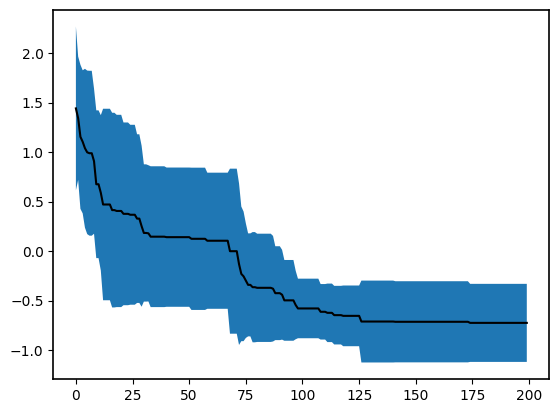

In [4]:
#@title plotting the experimental optimizations over time

norm_met = np.load(data_folder + 'norm_met.npy')
met_std = np.load(data_folder + 'met_std.npy')
met_mean = np.load(data_folder + 'met_mean.npy')
subj_inds = np.load(data_folder + 'subj_inds.npy')
len_dat = 200
met_data = np.zeros((len(subj_inds)-1,len_dat))
for i in range(len(subj_inds)-1):
    start = subj_inds[i]
    stop = subj_inds[i+1]
    if stop-start > len_dat:
        stop = stop - (stop-start - len_dat)

    met_data[i,:stop-start] = norm_met[start:stop]
    if stop-start < len_dat:
        for j in range(stop-start, len_dat):
            met_data[i,j] = met_data[i,j-1]

mean_met = np.mean(met_data,axis=0)
best_min = np.zeros(met_data.shape)
for i in range(met_data.shape[1]):
    best_min[:,i] = np.amin(met_data[:,:i+1],axis=1)
mean_best = np.mean(best_min,axis=0)
std = np.std(best_min,axis=0)
def mov_avg(data, window_size):
    smooth = np.zeros(len(data)-window_size)
    for i in range(len(smooth)):
        smooth[i] = np.mean(data[i:i+window_size])
    return smooth

window_size = 10
smooth = mov_avg(mean_best, window_size) # change mean_best to mean_met to get the avg rather than minimum
smooth_mean = mov_avg(mean_met, window_size)
smooth_std = mov_avg(std, window_size)/2
smooth_mean_best = mov_avg(mean_best,3)
plt.figure()
#plt.plot(met_data.T)
plt.plot(mean_best*0.75+0.4,c='k')#np.mean(met_data,axis=0),c='k')
#plt.plot(smooth_mean_best,c='r')
#plt.plot(smooth, c='y')
plt.fill_between(np.arange(len(mean_best)),mean_best*0.75+0.4+std,mean_best*0.75+0.4-std)
plt.show()

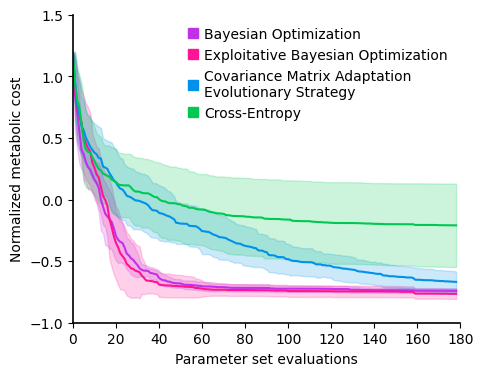

In [5]:
#@title Main 4-dim plot
#methods = ['hyb','bayes','tbay','cma','ce']
methods = ['bayes','tbay','cma','ce']
#methods_labels = {'tbay':'Decaying Bayesian Opt.', 'hyb':'Hybrid', 'ce':'Cross-Entropy', 'cma':'Covariance Matrix\nAdaptation (ES)', 'bayes':'Bayesian Opt'}
methods_labels = {'tbay':'Exploitative Bayesian Optimization', 'ce':'Cross-Entropy', 'cma':'Covariance Matrix Adaptation\nEvolutionary Strategy', 'bayes':'Bayesian Optimization'}
#m_c=[red, purple_as, purple, blue, green]
m_c=[purple_as, deep_pink, blue, green]
saving = True
dim = 4
num_runs = 8
min_total_samples = 180
f_eval_list = []
f_eval_min_list = []
for method in methods:
    f_eval = np.load(save_dir+method+"_feval_"+str(num_runs)+"_"+str(dim)+".npy")
    f_eval_min = np.load(save_dir+method+"_feval_min_"+str(num_runs)+"_"+str(dim)+".npy")
    f_eval_list.append(f_eval)
    f_eval_min_list.append(f_eval_min)
plot_methods(methods, smooth*0.75+0.4, smooth_std, f_eval_list, f_eval_min_list, "_"+str(num_runs)+"_"+str(dim), saving, m_c)

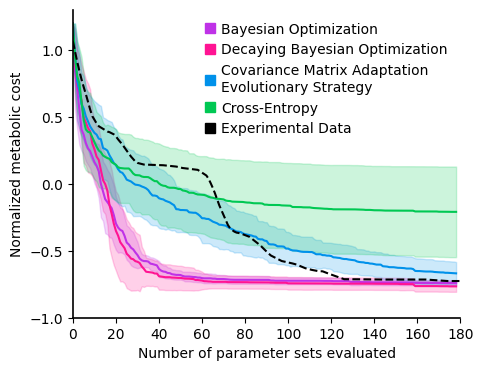

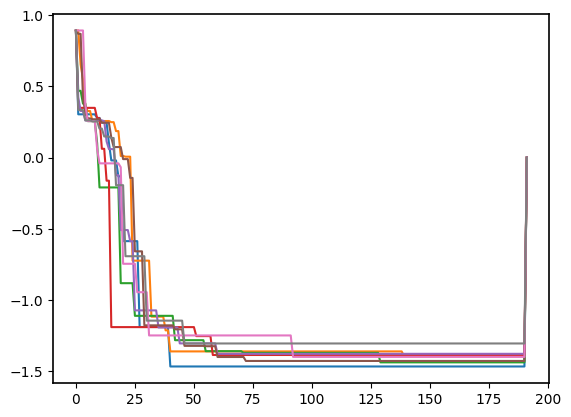

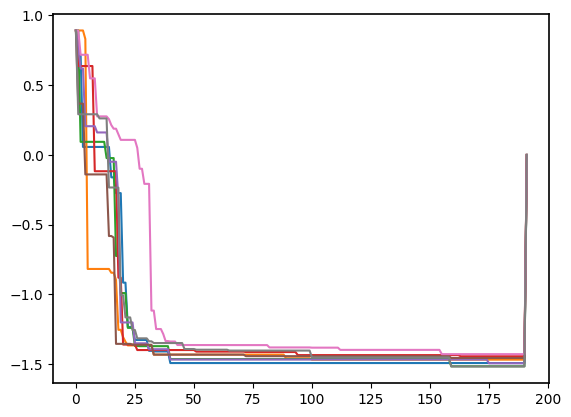

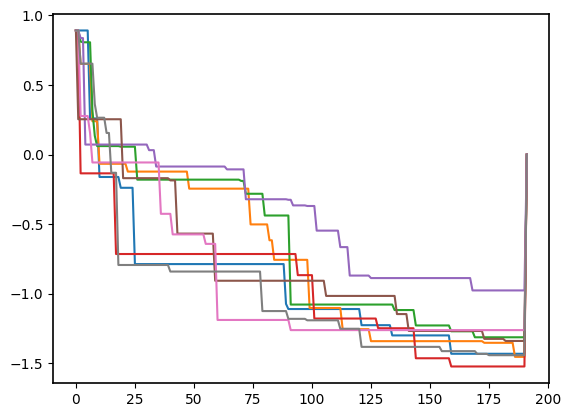

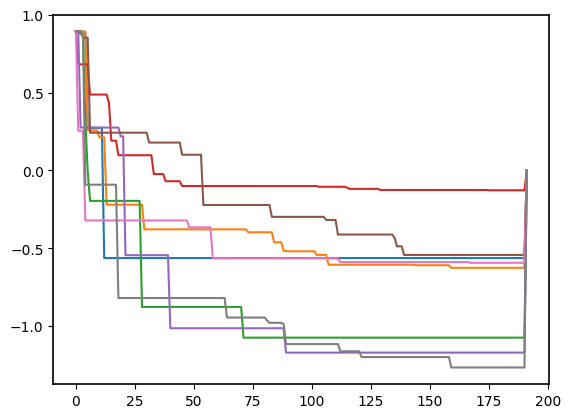

In [ ]:
plot_methods2(methods, smooth*0.75+0.4, smooth_std, f_eval_list, f_eval_min_list, "_"+str(num_runs)+"_"+str(dim), saving, m_c)

method:  bayes f_eval_min.shape:  (3, 19, 160)
method:  tbay f_eval_min.shape:  (3, 19, 192)
method:  cma f_eval_min.shape:  (3, 19, 160)
method:  ce f_eval_min.shape:  (3, 19, 160)


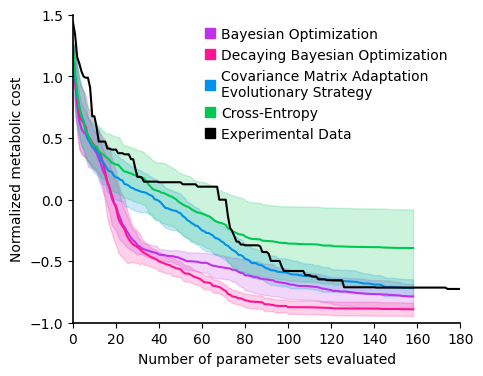

In [ ]:
# @title TV 4-dim plot
#methods = ['bayes','tbay','cma','ce']
#methods_labels = {'tbay':'Decaying Bayesian Opt.', 'ce':'Cross-Entropy', 'cma':'CMA-ES', 'bayes':'Bayesian Opt.'}
#m_c=[red, purple, blue, green]#purple_as
methods = ['bayes','tbay','cma','ce']
methods_labels = {'tbay':'Decaying Bayesian Optimization', 'ce':'Cross-Entropy', 'cma':'Covariance Matrix Adaptation\nEvolutionary Strategy', 'bayes':'Bayesian Optimization'}
m_c=[purple_as, deep_pink, blue, green]
saving = True
dim = 4
num_runs = 19
min_total_samples = 160
f_eval_list = []
f_eval_min_list = []
for method in methods:
    f_eval = np.load(save_dir+method+"_feval_"+str(num_runs)+"_"+str(dim)+".npy")
    f_eval_min = np.load(save_dir+method+"_feval_min_"+str(num_runs)+"_"+str(dim)+".npy")
    f_eval_list.append(f_eval)
    f_eval_min_list.append(f_eval_min)
#plot_methods_single(methods, f_eval_list, f_eval_min_list, "_"+str(num_runs)+"_"+str(dim)+"_tv", saving, m_c)
plot_methods_single(methods, mean_best, f_eval_list, f_eval_min_list, "_"+str(num_runs)+"_"+str(dim)+"_tv", saving, m_c)

# f_eval_min_list.append(mean_best*0.75+0.4)

4 Parameters  |  bayes | i =  0  | f_eval_min.shape (5, 8, 192)
4 Parameters  |  tbay | i =  1  | f_eval_min.shape (5, 8, 192)
4 Parameters  |  cma | i =  2  | f_eval_min.shape (5, 8, 192)
4 Parameters  |  ce | i =  3  | f_eval_min.shape (5, 8, 192)
12 Parameters  |  bayes | i =  0  | f_eval_min.shape (2, 10, 264)
12 Parameters  |  tbay | i =  1  | f_eval_min.shape (2, 10, 352)
12 Parameters  |  cma | i =  2  | f_eval_min.shape (2, 10, 264)
12 Parameters  |  ce | i =  3  | f_eval_min.shape (2, 10, 264)
20 Parameters  |  bayes | i =  0  | f_eval_min.shape (1, 5, 288)
20 Parameters  |  tbay | i =  1  | f_eval_min.shape (1, 5, 384)
20 Parameters  |  cma | i =  2  | f_eval_min.shape (1, 5, 288)
20 Parameters  |  ce | i =  3  | f_eval_min.shape (1, 5, 288)


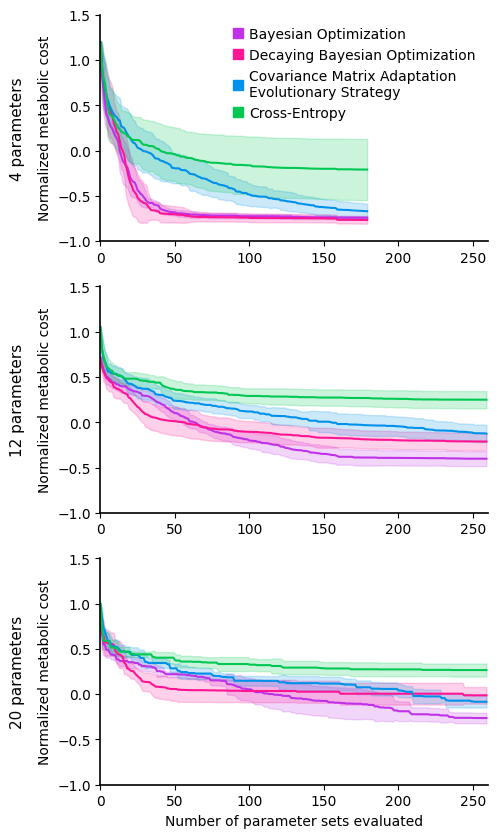

In [ ]:
#@title Plot optimization results for higher dimensional parameter spaces
# make overlaid plotting for the version with and without the moving cost function over time
def plot_dual_methods(methods, f_eval_list, f_eval_min_list, f_eval_list2, f_eval_min_list2, f_eval_list3, f_eval_min_list3, save_tag = "None", saving=False, m_c=[purple_as, blue, green], conv_thresh=0.1):
    fig, ax = plt.subplots(3, figsize=(5,10))
    param_list = ["4 Parameters", "12 Parameters", "20 Parameters"]
    f_eval_list_list = [f_eval_list, f_eval_list2, f_eval_list3]
    f_eval_min_list_list = [f_eval_min_list, f_eval_min_list2, f_eval_min_list3]
    stop_list = [180, 260, 260]
    #stop_list = [180, 180, 180]
    sc_list = []
    for j, p in enumerate(param_list):
        scatter_store = []
        for i, method in enumerate(methods):
            f_eval_min = f_eval_min_list_list[j][i] # [num subjs, num_runs, num_samples]
            print(p, " | ", method, "| i = ", i, " | f_eval_min.shape", f_eval_min.shape)
            # # Scaling
            # if j == 1: # 12 parameter case
            #   scaling = 3
            # elif j == 2: # 20 parameter case
            #   scaling = 5
            # else: # 4 parameter case
            #   scaling = 1
            # f_eval_min = f_eval_min / scaling
            f_eval_mean = np.mean(f_eval_min, axis=(0,1))[:stop_list[j]]
            f_eval_std = np.mean(np.std(f_eval_min, axis=1),axis=0)[:stop_list[j]]
            ax[j].plot(f_eval_mean, c=m_c[i], label=methods_labels[method])
            ax[j].fill_between(np.arange(len(f_eval_mean)),f_eval_mean + f_eval_std, f_eval_mean - f_eval_std, color=m_c[i], alpha = alpha)
            #ax[j].set_title(p)

            f_eval = f_eval_list_list[j][i]#, axis=(0,1))[:min_total_samples]
            conv_x, conv_check, std_x = check_conv(f_eval, conv_thresh[j], stop_list[j]-1)
            func_val = f_eval_mean[int(np.minimum(conv_x, stop_list[j]-1))]
            scatter_store.append([conv_x, conv_check, std_x, func_val])
        sc_list.append(scatter_store)

    # for j, p in enumerate(param_list):
    #     scatter_store = sc_list[j]
    #     for i, method in enumerate(methods):
    #         conv_x, conv_check, std_x, scat_val = scatter_store[i]
    #         if conv_check:# and (conv_x < min_total_samples-1):
    #             ax[j].scatter(conv_x, scat_val, marker='*', color=m_c[i], s=150, zorder=20, edgecolors= "black")
    #         print(conv_x, std_x, method)
    for i in range(3):
        ax[i].set_ylabel("Normalized metabolic cost")
        #ax[i].set_xlabel("Evaluations")
        ax[i].set_ylim([-1.,1.5])
        ax[i].set_xlim([0,260])
        #ax[i].set_ylabel("Normalized metabolic cost")
        ax[i].spines['top'].set_color('none')
        ax[i].spines['right'].set_color('none')
    #l0, l1, l2 = ax[0], ax[1], ax[2]
    #fig.legend([ax[0], ax[1], ax[2]], loc='upper right', frameon=False, handler_map={plt.Line2D:HandlerLine2D(update_func=update_prop)})
    ax[0].legend(loc='upper right', frameon=False, handler_map={plt.Line2D:HandlerLine2D(update_func=update_prop)})
    ax[2].set_xlabel("Number of parameter sets evaluated")
    # ax[1].get_legend().remove()
    # ax[2].get_legend().remove()
    # handles, labels = [], []
    # for indiv_ax in ax:
    #   h, l = indiv_ax.get_legend_handles_labels()
    #   handles.extend(h)
    #   labels.extend(l)
    # fig.legend(handles, labels, loc='upper right', frameon=False, handler_map={plt.Line2D:HandlerLine2D(update_func=update_prop)})
    #plt.subplots_adjust(hspace=0.5)

    rows = ['{} parameters'.format(row) for row in ['4', '12', '20']]
    pad=5
    for a, row in zip([ax[0], ax[1], ax[2]], rows):
        a.annotate(row, xy=(0, 0.5), xytext=(-a.yaxis.labelpad - pad, 0), xycoords=a.yaxis.label, textcoords='offset points',fontsize=11, va='center', ha='right', rotation=90)

    if saving:
        save_fold = main_folder + 'plots/'
        filename = 'Fig7_ZK_feval_plot4' + save_tag
        plt.savefig(save_fold+filename+".svg", bbox_inches = 'tight', dpi=1200, pad_inches = 0)
        # plt.savefig(save_dir+filename+".eps", bbox_inches = 'tight', dpi=1200, pad_inches = 0)
        plt.savefig(save_fold+filename+".png", bbox_inches = 'tight', dpi=1200, pad_inches = 0)
    plt.show()

methods = ['bayes','tbay','cma','ce']
methods_labels = {'tbay':'Decaying Bayesian Optimization', 'ce':'Cross-Entropy', 'cma':'Covariance Matrix Adaptation\nEvolutionary Strategy', 'bayes':'Bayesian Optimization'}
# m_c=[red, purple_as, purple, blue, green]
m_c=[purple_as, deep_pink, blue, green]
dim = 4
num_runs = 8#10
dim2 = 12
num_runs2 = 10
dim3 = 20
num_runs3 = 5
f_eval_list = []
f_eval_min_list = []
min_total_samples = 260

met_cost_scaling1 = 1 # to divide by
met_cost_scaling2 = 4 # to divide by
met_cost_scaling3 = 6 # to divide by

for method in methods:
    f_eval = np.load(save_dir+method+"_feval_"+str(num_runs)+"_"+str(dim)+".npy")
    #print(method, " | type(f_eval) ", type(f_eval), " | f_eval.shape ", f_eval.shape)
    f_eval = np.divide(f_eval, met_cost_scaling1)
    f_eval_min = np.load(save_dir+method+"_feval_min_"+str(num_runs)+"_"+str(dim)+".npy")
    #print(method, " | type(f_eval_min) ", type(f_eval_min), " | f_eval_min.shape ", f_eval_min.shape)
    f_eval_min = np.divide(f_eval_min, met_cost_scaling1)
    f_eval_list.append(f_eval)
    f_eval_min_list.append(f_eval_min)
    #print(method, " | type(f_eval_list) ", type(f_eval_list), " | type(f_eval_min_list) ", type(f_eval_min_list))

f_eval_list2 = []
f_eval_min_list2 = []
for method in methods:
    f_eval2 = np.load(save_dir+method+"_feval_"+str(num_runs2)+"_"+str(dim2)+".npy")
    f_eval2 = np.divide(f_eval2, met_cost_scaling2)
    f_eval_min2 = np.load(save_dir+method+"_feval_min_"+str(num_runs2)+"_"+str(dim2)+".npy")
    f_eval_min2 = np.divide(f_eval_min2, met_cost_scaling2)
    f_eval_list2.append(f_eval2)
    f_eval_min_list2.append(f_eval_min2)

f_eval_list3 = []
f_eval_min_list3 = []
for method in methods:
    f_eval3 = np.load(save_dir+method+"_feval_"+str(num_runs3)+"_"+str(dim3)+".npy")
    f_eval3 = np.divide(f_eval3, met_cost_scaling3)
    f_eval_min3 = np.load(save_dir+method+"_feval_min_"+str(num_runs3)+"_"+str(dim3)+".npy")
    f_eval_min3 = np.divide(f_eval_min3, met_cost_scaling3)
    f_eval_list3.append(f_eval3)
    f_eval_min_list3.append(f_eval_min3)

conv_thresh_list = [0.1, 0.2, 0.2]
plot_dual_methods(methods, f_eval_list, f_eval_min_list, f_eval_list2, f_eval_min_list2, f_eval_list3, f_eval_min_list3, "_"+str(num_runs)+"_"+str(dim)+'_comb', saving, m_c, conv_thresh_list)

In [ ]:
# visualize movement of mean and covariance
methods = ['cma']#'hyb','bayes','cma','ce']
methods_labels = {'hyb':'Hybrid', 'ce':'Cross-Entropy', 'cma':'Covariance Matrix\nAdaptation (ES)', 'bayes':'Bayesian\nOptimization'}
m_c=[red,purple_as, blue, green]
saving = True
dim = 4
num_runs = 8
min_total_samples = 180
f_eval_list = []
f_eval_min_list = []
for method in methods:
    f_eval = np.load(save_dir+method+"_feval_"+str(num_runs)+"_"+str(dim)+".npy")
    f_eval_min = np.load(save_dir+method+"_feval_min_"+str(num_runs)+"_"+str(dim)+".npy")
    mean = np.load(save_dir+method+"_mean_"+str(num_runs)+"_"+str(dim)+".npy")
    cov = np.load(save_dir+method+"_cov_"+str(num_runs)+"_"+str(dim)+".npy")

# load 1 GP

gp_dir = main_folder + 'save_GP/'
datasets = os.listdir(main_folder)
data_folder = main_folder + 'save_GP/_data/'
norm_met = np.load(data_folder + 'norm_met.npy')
met_std = np.load(data_folder + 'met_std.npy')
met_mean = np.load(data_folder + 'met_mean.npy')
subj_inds = np.load(data_folder + 'subj_inds.npy')

gp_fold = main_folder + 'save_GP/' + '1**2 + WhiteKernel(noise_level=1) + Matern(length_scale=1, nu=0.5)/'
gp = pkl.load(open(gp_fold+'m'+str(0)+'.dump','rb'))

param_std = np.load(data_folder + 'param_std.npy')
param_mean = np.load(data_folder + 'param_mean.npy')
norm_params = np.load(data_folder + 'norm_params.npy')
param_bounds = np.zeros((4,2))
param_bounds[0,:] = np.array([0,1.]) # max torque as % Nm/kg
param_bounds[1,:] = np.array([35,55]) # limits on peak time bounds
param_bounds[2,:] = np.array([10,40]) # rise/fall time bounds
param_bounds[3,:] = np.array([5,20]) # rise/fall time bounds
dims=4
norm_param_bounds = np.zeros((dims,2))
norm_param_bounds= (param_bounds - np.expand_dims(param_mean,axis=1))/np.expand_dims(param_std,axis=1)

axis_inds = np.array([[0,1],[2,3]])

param_min = norm_param_bounds[:,0]-0.4
param_max = norm_param_bounds[:,1]+0.4
numpts = 30
param_pts = np.linspace(param_min, param_max, numpts) # [numpts, dims]
param_labels = ['Peak torque', 'Peak time', 'Rise time', 'Fall time']
fig, ax = plt.subplots(2,axis_inds.shape[0],figsize=(7,8))#2*axis_inds.shape[0],3*(len(subj_l)-1)))
# Visualize different cross sections of the data
i = 0
for j in range(axis_inds.shape[0]):
    x,y = axis_inds[j]
    X,Y = np.meshgrid(param_pts[:,x],param_pts[:,y])
    test_slice = np.zeros((numpts,dims))
    Z = []
    for (r,p) in zip(X,Y):
        test_slice[:,x] = r
        test_slice[:,y] = p
        pred_slice_ij = gp.predict(test_slice, return_std = False)
        Z.append(pred_slice_ij)
    ct = ax[i,j].contour(X,Y,Z,levels=np.linspace(np.amin(norm_met),np.amax(norm_met),numpts),cmap='jet',linewidths=1)
    #sc = ax[i,j].scatter(x_data,y_data,c=z_data,cmap = 'jet',s=10)

    #cbar2 = fig.colorbar(ct, ax=ax[i,j])
    ax[i,j].set_ylabel(param_labels[y])
    ax[i,j].set_xlabel(param_labels[x])
    ax[i,j].set_ylim([param_min[y], param_max[y]])
    ax[i,j].set_xlim([param_min[x], param_max[x]])
    ax[i,j].set_yticks([], minor=False)
    ax[i,j].set_yticklabels([], minor=False)
    ax[i,j].set_xticks([], minor=False)
    ax[i,j].set_xticklabels([], minor=False)
    if j == axis_inds.shape[0]-1: # last one so plot the colorbar label
        cbar = fig.colorbar(ct, ax=ax[i,j])
        cbar.set_label('Normalized\nmetabolic cost')
from matplotlib.patches import Ellipse
print(cov.shape)
print(cov[0,0,:])
means = mean[0,0,:,:]
alpha = np.linspace(0.2,1.0,means.shape[0])
for j in range(axis_inds.shape[0]):
    x,y = axis_inds[j]
    for k in range(means.shape[0]):
        ax[i,j].scatter(means[k,x],means[k,y], alpha=alpha[k], c='r')
        ellipse = Ellipse([means[k,x],means[k,y]], cov[0,0,k], cov[0,0,k], fill=False, alpha=alpha[k])
        ax[i,j].add_patch(ellipse)

FileNotFoundError: [Errno 2] No such file or directory: 'drive/Shareddrives/Ability Lab/Simulating HILO/Code/save_GP/1**2 + WhiteKernel(noise_level=1) + Matern(length_scale=1, nu=0.5)/m0.dump'

In [ ]:
# scrap code testing other cma version

gp = m_l[0]
N = len(x_mean)
sigma = 1.0 # mult by something?
es = CMAEvolutionStrategy(N*[0], sigma)
iter_lim = 6
i = 0
while i <= iter_lim: #iter_limnot es.stop():
    solutions = es.ask()
    es.tell(solutions, [f(gp, x, meas_noise, x_mean, x_std) for x in solutions])
    es.logger.add()
    es.disp()
    i += 1
es.result_pretty()
es.logger.plot()